# Image Search

In [1]:
import base64

def encode_image(image_path):
    """Getting the base64 string with MIME type prefix"""
    with open(image_path, "rb") as image_file:
        # Read the file content
        file_content = image_file.read()
        
        # get content type
        file_ext = image_path.split("/")[-1].split(".")[-1]
        file_ext = file_ext.lower()
        if file_ext == "jpg":
            file_ext = "jpeg"
        mime_type = f"image/{file_ext}"

        # Encode the file content
        base64_encoded = base64.b64encode(file_content).decode("utf-8")
        
        # Return the result with the MIME type prefix
        return f"data:{mime_type};base64,{base64_encoded}"

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
import os
load_dotenv()

BUCKET_NAME = os.getenv("GOOGLE_CLOUD_STORAGE_BUCKET")
IMAGE_FOLDER = os.getenv("GOOGLE_CLOUD_STORAGE_BUCKET_IMAGE_FOLDER")
TYPESENSE_API_KEY = os.getenv("TYPESENSE_API_KEY")
TYPESENSE_COLLECTION = os.getenv("TYPESENSE_COLLECTION_NAME")
TAVILY_API_KEY = os.environ.get("TAVILY_API_KEY")

if BUCKET_NAME is None:
    raise ValueError("BUCKET_NAME is not set")
if IMAGE_FOLDER is None:
    raise ValueError("IMAGE_FOLDER is not set")
if TYPESENSE_API_KEY is None:
    raise ValueError("TYPESENSE_API_KEY is not set")
if TYPESENSE_COLLECTION is None:
    raise ValueError("TYPESENSE_COLLECTION is not set")
if TAVILY_API_KEY is None:
    raise ValueError("TAVILY_API_KEY is not set")

In [3]:
# import firebase_admin
# from firebase_admin import credentials, firestore

# # Uncomment if using service account key
# # cred = credentials.Certificate("../recyclesg-firebase-adminsdk-serviceAccountKey.json")
# # app = firebase_admin.initialize_app(
# #     credential=cred,
# # )

# # Use this if Application Default Credentials (ADC) have been set up
# app = firebase_admin.initialize_app()

# client = firestore.client()

In [5]:
import os
from google.cloud import firestore, storage

# The `project` parameter is optional and represents which project the client
# will act on behalf of. If not supplied, the client falls back to the default
# project inferred from the environment.
firestore_client = firestore.AsyncClient()
storage_client = storage.Client()
bucket_ref = storage_client.bucket(BUCKET_NAME)

In [7]:
# from typing import List, Optional
# from langchain_core.pydantic_v1 import BaseModel, Field
# from langchain_core.documents import Document


# # class ImageItemWithRetrievedDocs(BaseModel):
# #     item: str
# #     retrieved_docs: List[Document] = Field(default_factory=list)
# #     is_retrieved_docs_relevant: bool = Field(default=False)

# class QuestionWithDocs(BaseModel):
#     question: Optional[str] # Optional i.e. can be  `None`` if the user submitted an image, otherwise should be given a value if user asked a text question
#     item: Optional[str] # Optional i.e. can be  `None`` if the user asked a text question instead of submitting an image
#     docs: List[Document] = Field(default_factory=list)
#     is_docs_relevant: bool = Field(default=False)


In [6]:
import operator
from typing import Annotated, List, Optional, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.documents import Document

from langgraph.graph import StateGraph, START, END

# class State(BaseModel):
#     # for text questions
#     question: Optional[str]
#     retrieved_docs: List[Document] = Field(default_factory=list)
#     is_retrieved_docs_relevant: bool = Field(default=False)

#     # for image questions
#     image_items_with_docs: List[ImageItemWithRetrievedDocs] = Field(default_factory=list)

#     messages: Annotated[Sequence[BaseMessage], operator.add] = Field(default_factory=list)
#     generated_answer: str = Field(default="")

# class State(BaseModel):
#     questions_with_docs: List[QuestionWithDocs] = Field(default_factory=list)
#     messages: Annotated[Sequence[BaseMessage], operator.add] = Field(default_factory=list)
#     generated_answer: str = Field(default="")

class State(BaseModel):
    user_question: Optional[str]
    rephrased_question: str = Field(default="")
    items: List[str] = Field(default_factory=list)
    retrieved_docs: List[Document] = Field(default_factory=list)
    is_retrieved_docs_relevant: bool = Field(default=False)
    web_search_count: int = Field(default=0)
    messages: Annotated[Sequence[BaseMessage], operator.add] = Field(default_factory=list)
    generated_answer: str = Field(default="")

In [7]:
from langchain_openai import ChatOpenAI

vision_model = ChatOpenAI(model="gpt-4o", temperature=0)
LLM = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)

### Check if image is present
`is_image_present` node to check if the user has provided an image


In [8]:
from langchain_core.runnables import RunnableConfig

async def is_image_present(state: State, config: RunnableConfig):
    """Check if the user has provided an image for downstream tasks"""
    
    base64_image = config['configurable'].get('base64_image', None) # pass base64 image in the config instead of state to avoid persisting the image in the db via the checkpoiner
    if base64_image is None:
        return "no_image"
    return "has_image"

### Identify image items if image is present
`identify_image_items` node to identify the items in the image

In [9]:
VISION_MODEL_SYSTEM_MESSAGE = """
You are a helpful assistant that identifies items in an image, to be used for downstream tasks like answering recycling questions on the items.
"""

In [10]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

class ItemNames(BaseModel):
    items: List[str] = Field(
        description="Item names identified from the image"
    )


In [11]:
IMAGE_PROMPT = """
I have an image containing items that I am unsure of whether they are recyclable. Please help me to identify the item(s) in the image. If there are brand names in the image, ignore the brand names. Return the answer in JSON \n\n
The number of items in the `items` field in the JSON answer should be the same as the number of items you have identified in the image.
"""


In [12]:
from langchain_core.prompts import ChatPromptTemplate

image_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            VISION_MODEL_SYSTEM_MESSAGE,
        ),
        (
            "human",
            [
                {"type": "text", "text": IMAGE_PROMPT},
                {
                    "type": "image_url",
                    # "image_url": {"url": "data:image/jpeg;base64,{base64_image}"},
                    "image_url": {"url": "{base64_image}"},
                },
            ],
        ),
    ]
)

In [13]:
identify_items_chain = image_prompt_template | vision_model.with_structured_output(schema=ItemNames)

In [14]:
from langchain_core.runnables import RunnableConfig

async def identify_image_items(state: State, config: RunnableConfig):
    """Extract items from the image and return the items in the state
    
    Keyword arguments:
    state -- State object containing the question and context
    config -- RunnableConfig object containing the configuration
    Return: State object with the image items with docs
    """
    
    base64_image = config['configurable'].get('base64_image', None)
    if base64_image is None:
        raise ValueError("base64_image is required")
    
    identify_items_chain = image_prompt_template | vision_model.with_structured_output(schema=ItemNames)
    image_items = await identify_items_chain.ainvoke({"base64_image": base64_image}, config)
    image_items = [item for item in image_items.items]
    return {"items": image_items}

### Rephrase question based on image items (if image is present)
`rephrase_question_based_on_items` node to rephrase the user's question according to: image items (if image is present) and update the state with the rephrased question.

In [15]:
from langchain.prompts import PromptTemplate

# TODO: Update this prompt
REPHRASE_QUESTION_BASED_ON_ITEMS_PROMPT = PromptTemplate(
    template="""You are given a question and a list of items. Rephrase the question to be relevant to the items in the list, if necessary.
    Example 1 (one item):\n
    Question: "Can this be recycled? If not, what is the proper way to dispose of it?"\n
    Items: ["item1"]\n
    Rephrased Question: "Can item1 be recycled? If not, what is the proper way to dispose of it?"\n
    \n

    Example 2 (multiple items):\n
    Question: "Are these items recyclable?"\n
    Items: ["item1", "item2"]\n
    Rephrased Question: "Are item1 and item2 recyclable?"\n
    \n

    Example 3 (question already relevant to items):\n
    Question: "How to recycle thermal flask and plastic bottle?"\n
    Items: ["thermal flask", "plastic bottle"]\n
    Rephrased Question: "How to recycle thermal flask and plastic bottle?"\n
    \n

    Here is the question: {question} \n
    Here is the list of items: {items}
    """,
    input_variables=["question", "items"]
)

In [16]:
from langchain_core.output_parsers import StrOutputParser

rephrase_question_based_on_items_chain = REPHRASE_QUESTION_BASED_ON_ITEMS_PROMPT | LLM | StrOutputParser()
# res = rephrase_question_based_on_items_chain.invoke({"question": "How to recycle this?", "items": ["Plastic packaging", "Pizza box", "pen"]})
# print(res)

In [17]:
INDIV_ITEM_QUESTION_TEMPLATE = """

```is {item} recyclable? If so, please provide the instructions on how to recycle it properly.```

"""


async def rephrase_question_based_on_image_items(state: State, config: RunnableConfig):
    """Rephrase the user's question and update the state with the rephrased question.
    if image is present:
        If user has provided a question, rephrase that question with reference to the items identified from the image, if necessary.
        else if user has not provided a question, create a question using the items identified from the image, based on the template INDIV_ITEM_QUESTION_TEMPLATE.
    else:
        set the state's question to the user's question

    """
    
    # if user has provided a question, rephrase that question with reference to the items identified from the image.
    # else if user has not provided a question, create a question using the items identified from the image, based on the template INDIV_ITEM_QUESTION_TEMPLATE.
    rephrased_question = (
        await rephrase_question_based_on_items_chain.ainvoke(
            {"question": state.user_question, "items": state.items}
        )
        if state.user_question
        else "\n".join(
            [INDIV_ITEM_QUESTION_TEMPLATE.format(item=item) for item in state.items]
        )
    )
    if config['configurable'].get('debug', False):
        print("\n------- in rephrase_question_based_on_image_items node -------\n")
        print(f'rephrased question based on image items: {rephrased_question}')
    return {"rephrased_question": rephrased_question}

### Rephrase question based on chat history
`rephrase_question_based_on_chat_history` node to rephrase the user's question according to the chat history

In [18]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
    "If there is no chat history, return the user's question as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

In [19]:
# # testing out the prompt to rephrase question based on chat history
# from langchain_core.messages import HumanMessage, AIMessage
# from langchain_core.output_parsers import StrOutputParser

# ai_answer = """
# A Rubik's Cube is generally not recyclable due to its materials, which often include plastic and metal components that are not accepted by most recycling programs. The proper way to dispose of a Rubik's Cube is to consider donating it if it's still in good condition, or if it's broken, you can check for local electronic waste disposal programs that may accept it. Alternatively, you can also look for specialized recycling programs that handle plastic toys.

# Source:
# - Information obtained from external sources which might be inaccurate.
# """
# history = [HumanMessage(content="Can a Rubik's Cube be recycled? If not, what is the proper way to dispose of it?"), AIMessage(content=ai_answer)]


# rephrase_question_from_history_chain = contextualize_q_prompt | LLM | StrOutputParser()
# res = rephrase_question_from_history_chain.invoke({"input": "Why can't it be recycled?", "chat_history": history})
# res


In [20]:
rephrase_question_from_history_chain = contextualize_q_prompt | LLM | StrOutputParser()

In [21]:
# Usage example
# res = rephrase_question_from_history_chain.invoke({"input": "Why cant a thermal flask be recycled?", "chat_history": []})
# print(res)

In [22]:
async def rephrase_question_based_on_chat_history(state: State, config: RunnableConfig):
    """Rephrase the user's question based on the chat history and update the state with the rephrased question."""

    chat_history = [
        message
        for message in state.messages
        if message.additional_kwargs.get("custom-type") != "image"
    ]

    # use the user's question if the rephrased question is not provided i.e. no image is present. Question will first be rephrased based on image items if image is present, otherwise, there wont be a rephrased question.
    rephrased_question = (
        state.rephrased_question if state.rephrased_question else state.user_question
    )
    rephrased_question = await rephrase_question_from_history_chain.ainvoke(
        {"input": rephrased_question, "chat_history": chat_history}, config
    )
    if config["configurable"].get("debug", False):
        print("\n------- in rephrase_question_based_on_chat_history node -------\n")
        print(f"rephrased question: {rephrased_question}")
    return {"rephrased_question": rephrased_question}

## Retrieve docs
`retrieve_docs` node to retrieve docs based on item names via hybrid search (full text search + vector search)

In [23]:
from langchain_openai import OpenAIEmbeddings
import typesense


embedding_service = OpenAIEmbeddings(model='text-embedding-ada-002')

node = {
    "host": os.getenv("TYPESENSE_HOST"),  # For Typesense Cloud use xxx.a1.typesense.net
    "port": "443",       # For Typesense Cloud use 443
    "protocol": "https"    # For Typesense Cloud use https
}
typesense_client = typesense.Client(
    {
        "nodes": [node],
        "api_key": TYPESENSE_API_KEY,
        "connection_timeout_seconds": 5
    }
)

# vectorstore = Typesense(
#     typesense_client=typesense_client,
#     embedding=embedding_service,
#     typesense_collection_name=typesense_collection_name,
#     text_key="item",
# )

In [24]:
# using own implementation of hybrid search via Typesense as the Typesense support from langchain core is quite limited in functionality (only vector search), no support for hybrid search
from langchain_core.documents import Document
import json

def hybrid_search(query: str, k: int = 10, alpha: float= 0.3):
    """Perform hybrid search on the Typesense vector database
    
    Keyword arguments:
    query: str -- the query to search for
    k: int -- the number of results to return
    alpha: float [0,1] -- the weight given to the semantic (vector) search. (1 - alpha) is the weight given to the keyword search.
    """
    
    query_obj = {
        "collection"                 : TYPESENSE_COLLECTION,
        'q'                          : query,
        'query_by'                   : 'vec,item,instructions',
        "prefix"                     : "false",
        "vector_query"               : f"vec:([], alpha: {alpha})",  # alpha is weight given to semantic (vector) search, (1 - alpha) is weight given to keyword search
        "exclude_fields"             : "vec",
        "limit"                      : k,
    }

    common_search_params = {}

    response = typesense_client.multi_search.perform({"searches": [query_obj]}, common_search_params)

    docs = []
    for hit in response["results"][0]["hits"]:
        document = hit["document"]
        content = json.dumps({
            "item": document["item"],
            "instructions": document["instructions"],
            "material": document["material"],
            "recyclable": document["recyclable"],
            "links": document["links"]
        })
        # score = hit['hybrid_search_info']['rank_fusion_score']
        # docs.append((Document(page_content=content), score))
        docs.append(Document(page_content=content, metadata={"source": "database"}))
    return docs


In [25]:
async def retrieve_docs(state: State, config: RunnableConfig):
    """Retrieve docs from the database and adds them to the state:
        - based on image items (if image is present)
        - based on question
    """
    retrieved_docs = []
    unique_docs = set() # to avoid duplicate docs
    # retrieve docs based on image items (if there are image items)
    for item in state.items:
        docs: List[Document] = hybrid_search(item, k = 10)
        for doc in docs:
            if doc.page_content not in unique_docs:
                retrieved_docs.append(doc)
                unique_docs.add(doc.page_content)

    # retrieve docs based on user's question
    if rephrased_question:= state.rephrased_question:
        docs: List[Document] = hybrid_search(rephrased_question, k = 10, alpha = 1) # perform vector search (alpha = 1) on the question
        for doc in docs:
            if doc.page_content not in unique_docs:
                retrieved_docs.append(doc)
                unique_docs.add(doc.page_content)
        
    if config['configurable'].get('debug', False):
        print("\n------- in retrieve_docs node-------\n")
        print(f"retrieved docs: {retrieved_docs}")
    return {"retrieved_docs": retrieved_docs}


### Grade retrieved docs' relevance
`grade_retrieved_docs` node to grade the relevance of the retrieved docs in answering the question

In [26]:
from langchain.prompts import PromptTemplate 

GRADE_RETRIEVED_DOCS_PROMPT = PromptTemplate(
    template="""You are a grader assessing relevance of retrieved documents to a question. \n
    Return the output as a JSON with an `is_relevant` field being a Boolean True or False to indicate whether the documents contain the answer or not. \n
    Here are the retrieved documents: \n\n{retrieved_documents} \n\n
    Here is the question: {question} \n
    """,
    input_variables=["question", "retrieved_documents"]
)

In [27]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

class RetrievedDocsRelevance(BaseModel):
    is_relevant: bool = Field(
        description="Boolean True or False to indicate whether the documents contain the answer to answer the question"
    )


In [28]:
grade_retrieved_docs_chain = GRADE_RETRIEVED_DOCS_PROMPT | LLM.with_structured_output(schema=RetrievedDocsRelevance)

In [29]:
from typing import Literal
async def grade_retrieved_docs(state: State, config: RunnableConfig):
    res = await grade_retrieved_docs_chain.ainvoke({"question": state.rephrased_question, "retrieved_documents": state.retrieved_docs}, config=config)
    if config['configurable'].get('debug', False):  
        print("\n--------in grade_retrieved_docs node--------\n")
        print(f"Is retrieved docs relevant for question {state.rephrased_question}: {res.is_relevant}")
    return {"is_retrieved_docs_relevant": res.is_relevant}
    

### Perform web search
`perform_web_search` node to perform web search to update the retrieved docs with web search results if the retrieved docs do not contain the answer to answer the question

In [30]:
web_search_tool = TavilySearchResults(
    include_domains=["https://recyclopedia.sg/items"],
    search_depth="advanced",
    max_results=10,
    include_answer=True,
)

In [31]:
from typing import Literal
async def should_do_web_search(state: State, config: RunnableConfig) -> Literal["web_search_needed", "web_search_not_needed"]:
    if config['configurable'].get('debug', False):
        print("\n--------in should_do_web_search node--------")

    if state.is_retrieved_docs_relevant:
        print("Retrieved docs are relevant, no need to perform web search")
        return "web_search_not_needed"
    else:
        max_web_search_count = config["configurable"].get("max_web_search_count", 5)
        if state.web_search_count < max_web_search_count:
            if config['configurable'].get('debug', False):
                print(f"Current web search count: {state.web_search_count}. Web search needed")
            return "web_search_needed"
        else:
            if config['configurable'].get('debug', False):
                print(f"Max web search count reached: {max_web_search_count}. Stopping web search")
            return "stop_web_search"
    

In [32]:
# region: Old code where each image item is asked a question
# IMAGE_QUESTION = "is {item} recyclable? If so, please provide the instructions on how to recycle it properly."


# def convert_web_search_res_to_document(web_search_result):
#     doc = Document(
#         page_content=web_search_result["content"],
#         metadata={"source": web_search_result["url"]},
#     )
#     return doc


# async def perform_web_search(state: State, config: RunnableConfig):
#     """Perform web search to retrieve relevant documents for each image item (if user uploaded image) or text question (if user asked text question)

#     Keyword arguments:
#     state -- State object containing the image items with docs
#     Return: State object with the image items with irrelevant docs replaced with web search results
#     """
#     print("\n--------in perform_web_search node--------")
#     # region: websearch for text questions
#     if (
#         len(state.questions_with_docs) == 1
#         and state.questions_with_docs[0].question is not None
#     ):
#         print("\n------- performing web search for text question-------")
#         question = state.questions_with_docs[0].question
#         web_search_retrieved_docs = await web_search_tool.ainvoke(
#             {"query": question}, config=config
#         )
#         for i in range(len(web_search_retrieved_docs)):
#             web_search_retrieved_docs[i] = [
#                 convert_web_search_res_to_document(doc)
#                 for doc in web_search_retrieved_docs[i]
#             ]
#         state.questions_with_docs[0].docs = web_search_retrieved_docs
#         # replace the irrelevant retrieved docs with the web search retrieved docs
#         return {"questions_with_docs": state.questions_with_docs}
#     # endregion

#     # find indexes of image items have irrelevant docs
#     image_items_with_docs = state.questions_with_docs
#     image_items_with_irrelevant_docs_indexes = [
#         i
#         for i, item_with_docs in enumerate(image_items_with_docs)
#         if not item_with_docs.is_docs_relevant
#     ]
#     image_items_with_irrelevant_docs = [
#         image_items_with_docs[i] for i in image_items_with_irrelevant_docs_indexes
#     ]

#     # debugging
#     items_for_web_search = [
#         image_items_with_docs[i].item for i in image_items_with_irrelevant_docs_indexes
#     ]
#     print(
#         f"Performing web search for items: {','.join(items_for_web_search)}", end="\n"
#     )

#     web_search_retrieved_docs = await web_search_tool.abatch(
#         [
#             {"query": IMAGE_QUESTION.format(item=item_with_docs.item)}
#             for item_with_docs in image_items_with_irrelevant_docs
#         ],
#         config=config,
#     )  # web_search_retrieved_docs is [[{content1, url1}, {content2, url2}, ...], [{content1, url1}, {content2, url2}, ...]]
#     for i in range(len(web_search_retrieved_docs)):
#         web_search_retrieved_docs[i] = [
#             convert_web_search_res_to_document(doc)
#             for doc in web_search_retrieved_docs[i]
#         ]

#     # replace the irrelevant docs with the web search retrieved docs
#     for i in range(len(image_items_with_irrelevant_docs_indexes)):
#         irrelevant_docs_index = image_items_with_irrelevant_docs_indexes[i]
#         image_items_with_docs[irrelevant_docs_index].docs = web_search_retrieved_docs[i]
#         print(
#             f"Replaced irrelevant docs for item: {image_items_with_docs[irrelevant_docs_index].item} with web search results"
#         )

#     return {"image_items_with_docs": image_items_with_docs}
# endregion


In [33]:
async def perform_web_search(state: State, config: RunnableConfig):
    """Perform web search to add documents to the retrieved docs"""

    web_search_docs = await web_search_tool.ainvoke(
        {"query": state.rephrased_question}, config=config
    )
    # print(f"no. of web search docs: {len(web_search_docs)}")
    # print(f"web search docs: {web_search_docs}")
    
    # convert web search docs to Document objects
    for i in range(len(web_search_docs)):
        web_search_docs[i] = Document(
            page_content=web_search_docs[i]["content"],
            metadata={"source": web_search_docs[i]["url"]},
        )
    retrieved_docs = state.retrieved_docs + web_search_docs

    if config['configurable'].get('debug', False):
        print("\n--------in perform_web_search node--------\n")
        print(f"retrieved_docs: {retrieved_docs}")
    return {"retrieved_docs": retrieved_docs, "web_search_count": state.web_search_count + 1}

### Generate answer
`generate_answer` node to generate answer from retrieved docs

In [34]:
ANS_GEN_PROMPT = PromptTemplate(
    template="""
    You are given question(s) and a context to refer to, to answer the question(s). \n
    For each question, answer the question based on the context. \n
    Answer the question in a clear and concise human-readable format. Include markdown formatting if necessary. \n
    When answering the question, state the source at the bottom of the answer where you got the answer from, from the context. \n
    If the answer is not in the context, do state that you are unable to find the answer from the knowledge base to answer the question, and then use your knowledge to answer the question,  \n
    Example format of answer for each question: \n
    <Answer> \n
    Source(s):
    - <Source 1 web url link obtained from `links` field or `source` field in the context. If there is no url link present in the context, return ```Information derived from own knowledge database.``` or ```Information derived from pre-trained knowledge``` if the information was from your own knowledge>
    - ... \n
    \n
    Here are the question(s): \n
    ```
    {questions} \n
    ```
    \n\n

    Here is the context: \n
    ```
    {context}
    ```
    \n\n

    """,
    input_variables=["questions", "context"]
)

ans_gen_chain = ANS_GEN_PROMPT | LLM | StrOutputParser()

In [35]:
ANS_GEN_FROM_LLM_PROMPT = PromptTemplate(
    template="""
    Use your knowledge to answer the question. \n
    This is how your answer should be formatted: \n
    <Insert your answer here> \n
    Source:
    - Information obtained from external sources which might be inaccurate. 
    
    \n\n

    Here are the question(s): \n
    ```
    {questions} \n
    ```

    """,
    input_variables=["questions"]
)

ans_gen_from_llm_chain = ANS_GEN_FROM_LLM_PROMPT | LLM | StrOutputParser()


In [36]:
# res = ans_gen_chain.invoke({"questions": "is a crayon drawing recyclable?", "context": docs})
# print(res.content)

In [37]:
#region: Old code
# INDIV_ITEM_QUESTION = """is {item} recyclable? If so, please provide the instructions on how to recycle it properly. \n
# If {item} is not recyclable, please provide the instructions on how to dispose of it properly. \n
# """
# async def generate_answer(state: State, config: RunnableConfig):
#     """Generate answer from retrieved docs as context. Returns generic answer from LLM if answer is not found in context.
    
#     Keyword arguments:
#     state -- State object containing the question and context
#     Return: State object with the generated answer
#     """
#     print("\n--------in generate_answer node--------")
    
#     items_with_docs = state.image_items_with_docs
#     questions_with_context = []
#     for i, item_with_doc in enumerate(items_with_docs, start=1):
#         item_question = INDIV_ITEM_QUESTION.format(item=item_with_doc.item)
#         context = item_with_doc.retrieved_docs
#         question = QUESTION_WITH_CONTEXT.format(question_num=i, question=item_question, context=context)
#         questions_with_context.append(question)
#     answer = await ans_gen_chain.ainvoke({"questions_with_context": "\n\n".join(questions_with_context)}, config=config)
#     return {"generated_answer": answer}
# endregion: Old code

In [38]:
async def generate_answer(state: State, config: RunnableConfig):
    """Generate answer from retrieved docs as context. Returns generic answer from LLM if answer is not found in context.
    """
    
    answer = await ans_gen_chain.ainvoke({"questions": state.rephrased_question, "context": state.retrieved_docs}, config=config)
    if config['configurable'].get('debug', False):
        print("\n--------in generate_answer node--------\n")
        print(f"Generated answer: {answer}")
    return {"generated_answer": answer}

In [39]:
async def generate_answer_from_llm(state: State, config: RunnableConfig):
    """Generate answer from LLM as fallback if answer is not found in context nor web search results.
    """
    
    answer = await ans_gen_from_llm_chain.ainvoke({"questions": state.rephrased_question}, config=config)
    if config['configurable'].get('debug', False):  
        print("\n--------in generate_answer from LLM node--------\n")
        print(f"Generated answer from LLM: {answer}")
    return {"generated_answer": answer}

### Persist chat messages into Firestore
`persist_chat_messages` to: 
- upload user image to Google Cloud Storage (GCS)
- save chat messages (user image, text messages) into Firestore

In [40]:
import re

def extract_image_data(data_url):
    # Regular expression pattern to match the content type and base64 data
    pattern = r"data:(?P<content_type>[\w/]+);base64,(?P<base64_data>.*)"
    
    # Try to match the pattern
    match = re.match(pattern, data_url)
    
    if match:
        # Extract content type and base64 data
        content_type = match.group("content_type")
        base64_data = match.group("base64_data")
        return content_type, base64_data
    else:
        raise ValueError(f"Invalid data URL format for base64 image. Example expected format: data:<content-type>/<image-format>;base64,<base64-image-data> \n Got: {data_url[:30]}...")

# # Example usage
# data_url = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAA..."
# content_type, base64_image = extract_image_data(data_url)

# if content_type and base64_image:
#     print(f"Content Type: {content_type}")
#     print(f"Base64 Image Data: {base64_image[:50]}...")  # Print first 50 characters
# else:
#     print("Invalid data URL format")

In [41]:
from google.cloud.storage import Bucket
import base64
import io

def upload_base64_image_to_gcs(bucket_ref: Bucket, destination_blob_name: str, base64_image_data: str, content_type: str = "image/jpeg"):
    """Uploads a base64 encoded image to Google Cloud Storage.

    Args:
        bucket_ref (Bucket): The bucket reference to upload the image to.
        destination_blob_name (str): The name of the blob to create in GCS.
        base64_image_data (str): The base64 encoded image string.
        content_type (str): The content type of the image. Defaults to "image/jpeg".
    """
    
    # Decode the base64 string
    img_data = base64.b64decode(base64_image_data)

    # Create a file-like object from the decoded data
    file_obj = io.BytesIO(img_data)

    # Create a new blob and upload the file's content
    blob = bucket_ref.blob(destination_blob_name)
    blob.upload_from_file(file_obj, content_type=content_type)

    # Make the blob publicly accessible
    blob.make_public()

    # Get the public URL
    public_url = blob.public_url

    print(f"Public URL: {public_url}")
    return public_url

# Usage example
# with open("./encoded_image.txt", 'r') as file:
#     base64_image = file.read()
#     content_type, base64_image_data = extract_image_data(base64_image)
#     print(f'content_type: {content_type}')
#     upload_base64_image_to_gcs(bucket_ref, f"{IMAGE_FOLDER}/image3.jpg", base64_image_data, content_type)


In [42]:
from langchain_core.messages import HumanMessage, AIMessage
from typing import List
import uuid

async def persist_chat_messages(state: State, config: RunnableConfig):
    """Persist chat messages into Firestore"""
    if config['configurable'].get('debug', False):
        print("\n--------in persist_chat_messages node--------\n")
        
    messages: List[BaseMessage] = []
    # if there is a user image, upload onto cloud storage and persist the image url 
    if base64_image:=config["configurable"].get("base64_image", None):
        content_type, base64_image_data = extract_image_data(base64_image)
        file_extension = content_type.split("/")[1]
        image_url = upload_base64_image_to_gcs(bucket_ref, f"{IMAGE_FOLDER}/{uuid.uuid4()}.{file_extension}", base64_image_data, content_type)
        image_message = HumanMessage(content=image_url, additional_kwargs={"custom-type": "image"})
        messages.append(image_message)
    
    # if user question is present, add to messages
    if user_question:=state.user_question:
        messages.append(HumanMessage(content=user_question))
    
    # if generated answer is present, add to messages
    if generated_answer:=state.generated_answer:
        messages.append(AIMessage(content=generated_answer))

    return {"messages": messages} # returning list of messages to be added to the existing messages in state automatically

### Persisting conversation history to Firestore
[Reference from custom checkpoiner using mongodb](https://langchain-ai.github.io/langgraph/how-tos/persistence_mongodb/#how-to-create-a-custom-checkpointer-using-mongodb)

In [45]:
# region: old code
# Async
import pickle
from contextlib import AbstractContextManager
from types import TracebackType
from typing import Any, Dict, Iterator, Optional

from langchain_core.runnables import RunnableConfig
from typing_extensions import Self

from langgraph.checkpoint.base import (
    BaseCheckpointSaver,
    Checkpoint,
    CheckpointMetadata,
    CheckpointTuple,
    SerializerProtocol,
)
from langgraph.serde.jsonplus import JsonPlusSerializer
from google.cloud import firestore
from google.cloud.firestore_v1.base_query import FieldFilter

class JsonPlusSerializerCompat(JsonPlusSerializer):
    """A serializer that supports loading pickled checkpoints for backwards compatibility.

    This serializer extends the JsonPlusSerializer and adds support for loading pickled
    checkpoints. If the input data starts with b"\x80" and ends with b".", it is treated
    as a pickled checkpoint and loaded using pickle.loads(). Otherwise, the default
    JsonPlusSerializer behavior is used.

    Examples:
        >>> import pickle
        >>> from langgraph.checkpoint.sqlite import JsonPlusSerializerCompat
        >>>
        >>> serializer = JsonPlusSerializerCompat()
        >>> pickled_data = pickle.dumps({"key": "value"})
        >>> loaded_data = serializer.loads(pickled_data)
        >>> print(loaded_data)  # Output: {"key": "value"}
        >>>
        >>> json_data = '{"key": "value"}'.encode("utf-8")
        >>> loaded_data = serializer.loads(json_data)
        >>> print(loaded_data)  # Output: {"key": "value"}
    """

    def loads(self, data: bytes) -> Any:
        if data.startswith(b"\x80") and data.endswith(b"."):
            return pickle.loads(data)
        return super().loads(data)


class FirestoreDBSaver(AbstractContextManager, BaseCheckpointSaver):
    """A checkpoint saver that stores checkpoints in a Firestore database.

    Args:
        client (firestore.AsyncClient): The Async Firestore client.
        collection_name (str): The name of the collection to use.
        serde (Optional[SerializerProtocol]): The serializer to use for serializing and deserializing checkpoints. Defaults to JsonPlusSerializerCompat.
    """

    serde = JsonPlusSerializerCompat()
    client: firestore.AsyncClient
    collection_name: str

    def __init__(
        self,
        client: firestore.AsyncClient,
        collection_name: str,
        *,
        serde: Optional[SerializerProtocol] = None,
    ) -> None:
        super().__init__(serde=serde)
        self.client = client
        self.collection_name = collection_name
        self.collection = client.collection(collection_name)

    def __enter__(self) -> Self:
        return self

    def __exit__(
        self,
        __exc_type: Optional[type[BaseException]],
        __exc_value: Optional[BaseException],
        __traceback: Optional[TracebackType],
    ) -> Optional[bool]:
        return True

    async def aget_tuple(self, config: RunnableConfig) -> Optional[CheckpointTuple]:
        """Get a checkpoint tuple from the database.

        This method retrieves a checkpoint tuple from the Firestore database based on the
        provided config. If the config contains a "thread_ts" key, the checkpoint with
        the matching thread ID and timestamp is retrieved. Otherwise, the latest checkpoint
        for the given thread ID is retrieved.

        Args:
            config (RunnableConfig): The config to use for retrieving the checkpoint.

        Returns:
            Optional[CheckpointTuple]: The retrieved checkpoint tuple, or None if no matching checkpoint was found.
        """
        query = self.collection.where(filter=FieldFilter("thread_id", "==", config["configurable"]["thread_id"]))
        if config["configurable"].get("thread_ts"):
            query = query.where(filter=FieldFilter("thread_ts", "==", config["configurable"]["thread_ts"]))
            
        result = query.order_by("thread_ts", direction="DESCENDING").limit(1).stream()
        async for document in result:
            doc = document.to_dict()
            return CheckpointTuple(
                config,
                self.serde.loads(doc["checkpoint"]),
                self.serde.loads(doc["metadata"]),
                (
                    {
                        "configurable": {
                            "thread_id": doc["thread_id"],
                            "thread_ts": doc["parent_ts"],
                        }
                    }
                    if doc.get("parent_ts")
                    else None
                ),
            )

    async def alist(
        self,
        config: Optional[RunnableConfig],
        *,
        filter: Optional[Dict[str, Any]] = None,
        before: Optional[RunnableConfig] = None,
        limit: Optional[int] = None,
    ) -> Iterator[CheckpointTuple]:
        """List checkpoints from the database.

        This method retrieves a list of checkpoint tuples from the Firestore database based
        on the provided config. The checkpoints are ordered by timestamp in descending order.

        Args:
            config (RunnableConfig): The config to use for listing the checkpoints.
            before (Optional[RunnableConfig]): If provided, only checkpoints before the specified timestamp are returned. Defaults to None.
            limit (Optional[int]): The maximum number of checkpoints to return. Defaults to None.

        Yields:
            Iterator[CheckpointTuple]: An iterator of checkpoint tuples.
        """
        query = self.collection
        if config is not None:
            # query["thread_id"] = config["configurable"]["thread_id"]
            query = query.where(filter=FieldFilter("thread_id", "==", config["configurable"]["thread_id"]))
        if filter:
            for key, value in filter.items():
                # query[f"metadata.{key}"] = value
                query = query.where(filter=FieldFilter(f"metadata.{key}", "==", value))
        if before is not None:
            # query["thread_ts"] = {"$lt": before["configurable"]["thread_ts"]}
            query = query.where(filter=FieldFilter("thread_ts", "<", before["configurable"]["thread_ts"]))
        result = query.order_by("thread_ts", direction="DESCENDING").limit(limit).stream()
        async for document in result:
            doc = document.to_dict()
            yield CheckpointTuple(
                {
                    "configurable": {
                        "thread_id": doc["thread_id"],
                        "thread_ts": doc["thread_ts"],
                    }
                },
                self.serde.loads(doc["checkpoint"]),
                self.serde.loads(doc["metadata"]),
                (
                    {
                        "configurable": {
                            "thread_id": doc["thread_id"],
                            "thread_ts": doc["parent_ts"],
                        }
                    }
                    if doc.get("parent_ts")
                    else None
                ),
            )

    async def aput(
        self,
        config: RunnableConfig,
        checkpoint: Checkpoint,
        metadata: CheckpointMetadata,
    ) -> RunnableConfig:
        """Save a checkpoint to the database.

        This method saves a checkpoint to the Firestore database. The checkpoint is associated
        with the provided config and its parent config (if any).

        Args:
            config (RunnableConfig): The config to associate with the checkpoint.
            checkpoint (Checkpoint): The checkpoint to save.
            metadata (Optional[dict[str, Any]]): Additional metadata to save with the checkpoint. Defaults to None.

        Returns:
            RunnableConfig: The updated config containing the saved checkpoint's timestamp.
        """
        # print(f"config: {config}", end='\n\n')
        # print(f"checkpoint: {checkpoint}", end='\n\n')
        # print(f"metadata: {metadata}", end='\n\n')

        thread_id = config["configurable"]["thread_id"]
        doc = {
            "thread_id": thread_id,
            "thread_ts": checkpoint["id"],
            "checkpoint": self.serde.dumps(checkpoint),
            "metadata": self.serde.dumps(metadata),
        }
        if config["configurable"].get("thread_ts"):
            doc["parent_ts"] = config["configurable"]["thread_ts"]
        await self.collection.add(doc)
        return {
            "configurable": {
                "thread_id": config["configurable"]["thread_id"],
                "thread_ts": checkpoint["id"],
            }
        }
# endregion: old code


In [59]:
from contextlib import AbstractContextManager, asynccontextmanager
from types import TracebackType
from typing import Any, AsyncIterator, Dict, Iterator, Optional, Sequence, Tuple

from langchain_core.runnables import RunnableConfig
from typing_extensions import Self

from langgraph.checkpoint.base import (
    BaseCheckpointSaver,
    ChannelVersions,
    Checkpoint,
    CheckpointMetadata,
    CheckpointTuple,
    get_checkpoint_id,
)
from google.cloud import firestore
from google.cloud.firestore_v1.base_query import FieldFilter

#Async
class AsyncFirestoreDBSaver(BaseCheckpointSaver):
    """A checkpoint saver that stores checkpoints in a Firestore database asynchronously."""

    client: firestore.AsyncClient
    checkpoints_collection: firestore.AsyncCollectionReference
    checkpoint_writes_collection: firestore.AsyncCollectionReference
    batch: firestore.AsyncWriteBatch

    def __init__(
        self,
        client: firestore.AsyncClient,
        checkpoints_collection_name: str,
        checkpoint_writes_collection_name: str,
    ) -> None:
        super().__init__()
        self.client = client
        self.checkpoints_collection = self.client.collection(checkpoints_collection_name)
        self.checkpoint_writes_collection = self.client.collection(checkpoint_writes_collection_name)
        self.batch = self.client.batch()
        
    @classmethod
    @asynccontextmanager
    async def from_conn_info(
        cls,
        *,
        checkpoints_collection_name: str,
        checkpoint_writes_collection_name: str,
    ) -> AsyncIterator["AsyncFirestoreDBSaver"]:
        client = None
        try:
            client = firestore.AsyncClient()
            yield AsyncFirestoreDBSaver(client, checkpoints_collection_name, checkpoint_writes_collection_name)
        finally:
            if client:
                client.close()

    async def aget_tuple(self, config: RunnableConfig) -> Optional[CheckpointTuple]:
        """Get a checkpoint tuple from the database asynchronously.

        This method retrieves a checkpoint tuple from the Firestore database based on the
        provided config. If the config contains a "checkpoint_id" key, the checkpoint with
        the matching thread ID and checkpoint ID is retrieved. Otherwise, the latest checkpoint
        for the given thread ID is retrieved.

        Args:
            config (RunnableConfig): The config to use for retrieving the checkpoint.

        Returns:
            Optional[CheckpointTuple]: The retrieved checkpoint tuple, or None if no matching checkpoint was found.
        """
        thread_id = config["configurable"]["thread_id"]
        checkpoint_ns = config["configurable"].get("checkpoint_ns", "")
        query = self.checkpoints_collection.where(filter=FieldFilter("thread_id", "==", thread_id)).where(filter=FieldFilter("checkpoint_ns", "==", checkpoint_ns))
        if checkpoint_id := get_checkpoint_id(config):
            query = query.where(filter=FieldFilter("checkpoint_id", "==", checkpoint_id))
        result = query.order_by("checkpoint_id", direction="DESCENDING").limit(1).stream()
        async for doc in result:
            doc = doc.to_dict()
            checkpoint_id = doc["checkpoint_id"]
            config_values = {
                "thread_id": thread_id,
                "checkpoint_ns": checkpoint_ns,
                "checkpoint_id": checkpoint_id,
            }
            checkpoint = self.serde.loads_typed((doc["type"], doc["checkpoint"]))
            serialized_writes = self.checkpoint_writes_collection.where(filter=FieldFilter("thread_id", "==", thread_id)).where(filter=FieldFilter("checkpoint_ns", "==", checkpoint_ns)).where(filter=FieldFilter("checkpoint_id", "==", checkpoint_id)).stream()
            pending_writes = [
                (
                    doc["task_id"],
                    doc["channel"],
                    self.serde.loads_typed((doc["type"], doc["value"])),
                )
                async for doc in serialized_writes
            ]
            return CheckpointTuple(
                {"configurable": config_values},
                checkpoint,
                self.serde.loads(doc["metadata"]),
                (
                    {
                        "configurable": {
                            "thread_id": thread_id,
                            "checkpoint_ns": checkpoint_ns,
                            "checkpoint_id": doc["parent_checkpoint_id"],
                        }
                    }
                    if doc.get("parent_checkpoint_id")
                    else None
                ),
                pending_writes,
            )

    async def alist(
        self,
        config: Optional[RunnableConfig],
        *,
        filter: Optional[Dict[str, Any]] = None,
        before: Optional[RunnableConfig] = None,
        limit: Optional[int] = None,
    ) -> AsyncIterator[CheckpointTuple]:
        """List checkpoints from the database asynchronously.

        This method retrieves a list of checkpoint tuples from the Firestore database based
        on the provided config. The checkpoints are ordered by checkpoint ID in descending order (newest first).

        Args:
            config (Optional[RunnableConfig]): Base configuration for filtering checkpoints.
            filter (Optional[Dict[str, Any]]): Additional filtering criteria for metadata.
            before (Optional[RunnableConfig]): If provided, only checkpoints before the specified checkpoint ID are returned. Defaults to None.
            limit (Optional[int]): Maximum number of checkpoints to return.

        Yields:
            AsyncIterator[CheckpointTuple]: An asynchronous iterator of matching checkpoint tuples.
        """
        query = self.checkpoints_collection
        if config is not None:
            query = query.where(filter=FieldFilter("thread_id", "==", config["configurable"]["thread_id"]))
            if config["configurable"].get("checkpoint_ns", None):
                checkpoint_ns = config["configurable"].get("checkpoint_ns")
                query = query.where(filter=FieldFilter("checkpoint_ns", "==", checkpoint_ns))
            
        if filter:
            for key, value in filter.items():
                query = query.where(filter=FieldFilter(f"metadata.{key}", "==", value))

        if before is not None:
            query = query.where(filter=FieldFilter("checkpoint_id", "<", before["configurable"]["checkpoint_id"]))

        result = query.order_by("checkpoint_id", direction="DESCENDING")

        if limit is not None:
            result = result.limit(limit)
        async for doc in result.stream():
            doc = doc.to_dict()
            checkpoint = self.serde.loads_typed((doc["type"], doc["checkpoint"]))
            yield CheckpointTuple(
                {
                    "configurable": {
                        "thread_id": doc["thread_id"],
                        "checkpoint_ns": doc["checkpoint_ns"],
                        "checkpoint_id": doc["checkpoint_id"],
                    }
                },
                checkpoint,
                self.serde.loads(doc["metadata"]),
                (
                    {
                        "configurable": {
                            "thread_id": doc["thread_id"],
                            "checkpoint_ns": doc["checkpoint_ns"],
                            "checkpoint_id": doc["parent_checkpoint_id"],
                        }
                    }
                    if doc.get("parent_checkpoint_id")
                    else None
                ),
            )

    async def aput(
        self,
        config: RunnableConfig,
        checkpoint: Checkpoint,
        metadata: CheckpointMetadata,
        new_versions: ChannelVersions,
    ) -> RunnableConfig:
        """Save a checkpoint to the database asynchronously.

        This method saves a checkpoint to the Firestore database. The checkpoint is associated
        with the provided config and its parent config (if any).

        Args:
            config (RunnableConfig): The config to associate with the checkpoint.
            checkpoint (Checkpoint): The checkpoint to save.
            metadata (CheckpointMetadata): Additional metadata to save with the checkpoint.
            new_versions (ChannelVersions): New channel versions as of this write.

        Returns:
            RunnableConfig: Updated configuration after storing the checkpoint.
        """
        thread_id = config["configurable"]["thread_id"]
        checkpoint_ns = config["configurable"]["checkpoint_ns"]
        checkpoint_id = checkpoint["id"]
        type_, serialized_checkpoint = self.serde.dumps_typed(checkpoint)
        doc = {
            "parent_checkpoint_id": config["configurable"].get("checkpoint_id"),
            "type": type_,
            "checkpoint": serialized_checkpoint,
            "metadata": self.serde.dumps(metadata),
            "thread_id": thread_id,
            "checkpoint_ns": checkpoint_ns,
            "checkpoint_id": checkpoint_id,
        }
        # upsert_query = {
        #     "thread_id": thread_id,
        #     "checkpoint_ns": checkpoint_ns,
        #     "checkpoint_id": checkpoint_id,
        # }
        # Perform your operations here
        # await self.db["checkpoints"].update_one(
        #     upsert_query, {"$set": doc}, upsert=True
        # )
        # Upsert in firestore
        # Query to find the document
        query = self.checkpoints_collection.where(filter=FieldFilter("thread_id", "==", thread_id)) \
                                        .where(filter=FieldFilter("checkpoint_ns", "==", checkpoint_ns)) \
                                        .where(filter=FieldFilter("checkpoint_id", "==", checkpoint_id))

        # Get the document snapshot
        docs = await query.limit(1).get()
        
        if docs:
            # Document exists, update it
            doc_ref: firestore.AsyncDocumentReference = docs[0].reference
            await doc_ref.set(doc, merge=True)
        else:
            # Document does not exist, create a new one
            await self.checkpoints_collection.add(doc)
        return {
            "configurable": {
                "thread_id": thread_id,
                "checkpoint_ns": checkpoint_ns,
                "checkpoint_id": checkpoint_id,
            }
        }

    async def aput_writes(
        self,
        config: RunnableConfig,
        writes: Sequence[Tuple[str, Any]],
        task_id: str,
    ) -> None:
        """Store intermediate writes linked to a checkpoint asynchronously.

        This method saves intermediate writes associated with a checkpoint to the database.

        Args:
            config (RunnableConfig): Configuration of the related checkpoint.
            writes (Sequence[Tuple[str, Any]]): List of writes to store, each as (channel, value) pair.
            task_id (str): Identifier for the task creating the writes.
        """
        thread_id = config["configurable"]["thread_id"]
        checkpoint_ns = config["configurable"]["checkpoint_ns"]
        checkpoint_id = config["configurable"]["checkpoint_id"]
        # operations = []
        # for idx, (channel, value) in enumerate(writes):
        #     upsert_query = {
        #         "thread_id": thread_id,
        #         "checkpoint_ns": checkpoint_ns,
        #         "checkpoint_id": checkpoint_id,
        #         "task_id": task_id,
        #         "idx": idx,
        #     }
        #     type_, serialized_value = self.serde.dumps_typed(value)
        #     operations.append(
        #         UpdateOne(
        #             upsert_query,
        #             {
        #                 "$set": {
        #                     "channel": channel,
        #                     "type": type_,
        #                     "value": serialized_value,
        #                 }
        #             },
        #             upsert=True,
        #         )
        #     )
        # await self.db["checkpoint_writes"].bulk_write(operations) 
        for idx, (channel, value) in enumerate(writes):
            type_, serialized_value = self.serde.dumps_typed(value)
            query = self.checkpoint_writes_collection.where(filter=FieldFilter("thread_id", "==", thread_id)) \
                                        .where(filter=FieldFilter("checkpoint_ns", "==", checkpoint_ns)) \
                                        .where(filter=FieldFilter("checkpoint_id", "==", checkpoint_id)) \
                                        .where(filter=FieldFilter("task_id", "==", task_id)) \
                                        .where(filter=FieldFilter("idx", "==", idx))
            docs: List[firestore.DocumentSnapshot] = await query.limit(1).get()
            if docs:
                doc_ref = docs[0].reference
            else:
                # create the doc if the doc does not exist
                doc_ref = self.checkpoint_writes_collection.document()
            doc = {
                "thread_id": thread_id,
                "checkpoint_ns": checkpoint_ns,
                "checkpoint_id": checkpoint_id,
                "task_id": task_id,
                "idx": idx,
                "channel": channel,
                "type": type_,
                "value": serialized_value,
            }
            self.batch.set(doc_ref, doc, merge=True)
        await self.batch.commit()

In [50]:
from IPython.display import Image, display

graph_builder = StateGraph(State)
# checkpointer = FirestoreDBSaver(client, "HistoryMessages")

graph_builder.add_node("identify_image_items", identify_image_items)
graph_builder.add_node("rephrase_question_based_on_image_items", rephrase_question_based_on_image_items)
graph_builder.add_node("rephrase_question_based_on_chat_history", rephrase_question_based_on_chat_history)
graph_builder.add_node("retrieve_docs", retrieve_docs)
graph_builder.add_node("grade_retrieved_docs", grade_retrieved_docs)
graph_builder.add_node("perform_web_search", perform_web_search)
graph_builder.add_node("generate_answer", generate_answer)
graph_builder.add_node("generate_answer_from_llm", generate_answer_from_llm)
graph_builder.add_node("persist_chat_messages", persist_chat_messages)

graph_builder.add_conditional_edges(
    START,
    is_image_present,
    {"has_image": "identify_image_items", "no_image": "rephrase_question_based_on_chat_history"},
)
graph_builder.add_edge("identify_image_items", "rephrase_question_based_on_image_items")
graph_builder.add_edge("rephrase_question_based_on_image_items", "rephrase_question_based_on_chat_history")
graph_builder.add_edge("rephrase_question_based_on_chat_history", "retrieve_docs")
graph_builder.add_edge("retrieve_docs", "grade_retrieved_docs")

graph_builder.add_edge("perform_web_search", "grade_retrieved_docs")

graph_builder.add_conditional_edges(
    "grade_retrieved_docs",
    should_do_web_search,
    {"web_search_not_needed": "generate_answer", "web_search_needed": "perform_web_search", "stop_web_search": "generate_answer_from_llm"},
)

graph_builder.add_edge("generate_answer", "persist_chat_messages")
graph_builder.add_edge("generate_answer_from_llm", "persist_chat_messages")
graph_builder.add_edge("persist_chat_messages", END)


# uncomment to visualize the graph
# graph = graph_builder.compile()
# try:
#     display(Image(graph.get_graph().draw_mermaid_png()))
# except Exception:
#     # This requires some extra dependencies and is optional
#     pass

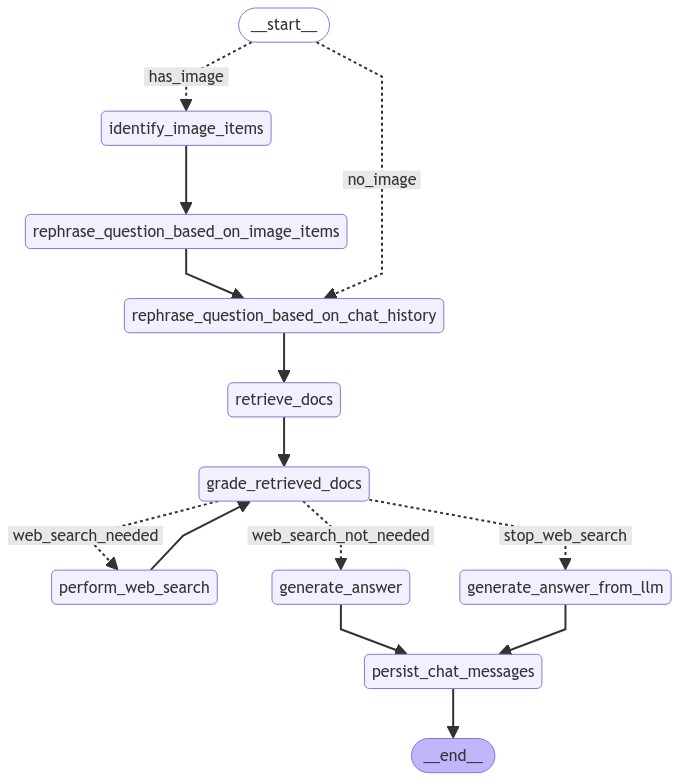

In [69]:
# TESTING
# base64_image = encode_image("../images/difficult/mouse and monitor.webp")
# base64_image = encode_image("../images/metal-container_cover.JPEG")
# base64_image = encode_image("../images/plastic-bubble_wrap.JPEG")
# base64_image = encode_image("../images/rubik cube.jpg")

base64_image = encode_image("../images/test/batch1/Melamine cups (2).jpeg")

In [49]:
# save base64_image to file
with open("./encoded_image.txt", "w") as f:
    f.write(base64_image)

In [65]:
async with AsyncFirestoreDBSaver.from_conn_info(
    checkpoints_collection_name="checkpoints",
    checkpoint_writes_collection_name="checkpoint_writes",
) as checkpointer:
    graph = graph_builder.compile(checkpointer=checkpointer)
    

In [72]:
state = State(user_question="Can you help me identify the items in the image? Like what kind of items are there?")
# state = State()

events = []
config = {
    "configurable": {
        "thread_id": "138",
        # "base64_image": base64_image,
        "max_web_search_count": 5,
        "debug": False,
    }
}
async for event in graph.astream_events(state.dict(), config, version="v2"):
    events.append(event)
    kind = event["event"]
    langgraph_node = event["metadata"].get("langgraph_node", None)
    name = event["name"]

    if kind == "on_chain_start":
        if (
            name == "identify_image_items"
            and langgraph_node == "identify_image_items"
        ):
            print(f"Identifying items from image...")
        elif (
            name == "rephrase_question_based_on_image_items"
            and langgraph_node == "rephrase_question_based_on_image_items"
        ):
            print(f"Rephrasing question based on image items...")
        elif (
            name == "rephrase_question_based_on_chat_history"
            and langgraph_node == "rephrase_question_based_on_chat_history"
        ):
            print(f"Rephrasing question based on chat history...")
        elif name == "retrieve_docs" and langgraph_node == "retrieve_docs":
            print(f"Retrieving documents...")
        elif (
            name == "grade_retrieved_docs"
            and langgraph_node == "grade_retrieved_docs"
        ):
            print(f"Grading retrieved documents...")
        elif (
            name == "perform_web_search" and langgraph_node == "perform_web_search"
        ):
            print(f"Performing web search...")
        elif name == "generate_answer" and langgraph_node == "generate_answer":
            print(f"Generating answer...")
        elif (
            name == "generate_answer_from_llm"
            and langgraph_node == "generate_answer_from_llm"
        ):
            print(f"Generating answer from LLM...")

    elif kind == "on_chain_end":
        if (
            name == "identify_image_items"
            and langgraph_node == "identify_image_items"
        ):
            output = event["data"]["output"].get("items", None)
            msg = f"✓ Identified items from image: {','.join(output) if len(output) > 0 else 'None'}"
            print(msg)

        elif (
            name == "rephrase_question_based_on_chat_history"
            and langgraph_node == "rephrase_question_based_on_chat_history"
        ):
            rephrased_question = event["data"]["output"].get(
                "rephrased_question", None
            )
            msg = f"✓ Rephrased question: {rephrased_question}"
            print(msg)

        elif name == "retrieve_docs" and langgraph_node == "retrieve_docs":
            msg = f"✓ Retrieved documents"
            print(msg)

        elif (
            name == "grade_retrieved_docs"
            and langgraph_node == "grade_retrieved_docs"
        ):
            output = event["data"]["output"].get("is_retrieved_docs_relevant", None)
            msg = f"✓ Graded retrieved documents. {'Documents are relevant to question' if output else 'Documents are not relevant to question'}"
            print(msg)

        elif (
            name == "perform_web_search" and langgraph_node == "perform_web_search"
        ):
            msg = f"✓ Performed web search"
            print(msg)

        elif (
            name == "generate_answer" and langgraph_node == "generate_answer"
        ) or (
            name == "generate_answer_from_llm"
            and langgraph_node == "generate_answer_from_llm"
        ):
            generated_ans = event["data"]["output"].get("generated_answer", None)
            print(f"\n\nGenerated answer: {generated_ans}")

        elif name == "LangGraph":
            thread_id = config["configurable"].get("thread_id", None)
            print(f"Langgraph end. Thread ID: {thread_id}")

    elif kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if (
            langgraph_node == "generate_answer"
            or langgraph_node == "generate_answer_from_llm"
        ):
            if content:
                # Empty content in the context of OpenAI or Anthropic usually means
                # that the model is asking for a tool to be invoked.
                # So we only print non-empty content
                print(content, end="|")

Rephrasing question based on chat history...
✓ Rephrased question: Can you describe the items in the image or provide details about what they look like?
Retrieving documents...
✓ Retrieved documents
Grading retrieved documents...
✓ Graded retrieved documents. Documents are not relevant to question
Performing web search...
✓ Performed web search
Grading retrieved documents...
✓ Graded retrieved documents. Documents are not relevant to question
Performing web search...
✓ Performed web search
Grading retrieved documents...
✓ Graded retrieved documents. Documents are not relevant to question
Performing web search...
✓ Performed web search
Grading retrieved documents...
✓ Graded retrieved documents. Documents are not relevant to question
Performing web search...
✓ Performed web search
Grading retrieved documents...
✓ Graded retrieved documents. Documents are not relevant to question
Performing web search...
✓ Performed web search
Grading retrieved documents...
✓ Graded retrieved documents. 

In [62]:
await checkpointer.aget(config)

{'v': 1,
 'ts': '2024-08-11T10:29:12.363633+00:00',
 'id': '1ef57cc8-d144-6968-8007-5948ffcf6fe4',
 'channel_values': {'user_question': None,
  'rephrased_question': 'Are plastic bottles recyclable, and if so, what are the proper instructions for recycling them?',
  'items': ['plastic bottles'],
  'retrieved_docs': [Document(metadata={'source': 'database'}, page_content='{"item": "plastic milk bottles", "instructions": "Please empty and rinse before recycling.", "material": "F&B Plastic", "recyclable": true, "links": []}'),
   Document(metadata={'source': 'database'}, page_content='{"item": "plastic bodywash bottle", "instructions": "Please empty and rinse before recycling.", "material": "Non Food Plastic", "recyclable": true, "links": []}'),
   Document(metadata={'source': 'database'}, page_content='{"item": "plastic soft drink bottle", "instructions": "Please empty and rinse before recycling.", "material": "F&B Plastic", "recyclable": true, "links": []}'),
   Document(metadata={'sour

In [73]:
latest_checkpoint_tuple = await checkpointer.aget_tuple(config)
latest_checkpoint_tuple

CheckpointTuple(config={'configurable': {'thread_id': '138', 'checkpoint_ns': '', 'checkpoint_id': '1ef57cdc-8d48-6399-8021-6bc95445da75'}}, checkpoint={'v': 1, 'ts': '2024-08-11T10:38:02.105708+00:00', 'id': '1ef57cdc-8d48-6399-8021-6bc95445da75', 'channel_values': {'user_question': 'Can you help me identify the items in the image? Like what kind of items are there?', 'rephrased_question': 'Can you describe the items in the image or provide details about what they look like?', 'items': [], 'retrieved_docs': [Document(metadata={'source': 'database'}, page_content='{"item": "spectacles", "instructions": "Should be donated if they are in good condition.", "material": "Others", "recyclable": false, "links": []}'), Document(metadata={'source': 'database'}, page_content='{"item": "tissue box", "instructions": "Please flatten.", "material": "Paper", "recyclable": true, "links": []}'), Document(metadata={'source': 'database'}, page_content='{"item": "metal accessories", "instructions": "Make 

In [75]:
from pprint import pprint
pprint(latest_checkpoint_tuple)

CheckpointTuple(config={'configurable': {'thread_id': '138', 'checkpoint_ns': '', 'checkpoint_id': '1ef57cdc-8d48-6399-8021-6bc95445da75'}}, checkpoint={'v': 1, 'ts': '2024-08-11T10:38:02.105708+00:00', 'id': '1ef57cdc-8d48-6399-8021-6bc95445da75', 'channel_values': {'user_question': 'Can you help me identify the items in the image? Like what kind of items are there?', 'rephrased_question': 'Can you describe the items in the image or provide details about what they look like?', 'items': [], 'retrieved_docs': [Document(metadata={'source': 'database'}, page_content='{"item": "spectacles", "instructions": "Should be donated if they are in good condition.", "material": "Others", "recyclable": false, "links": []}'), Document(metadata={'source': 'database'}, page_content='{"item": "tissue box", "instructions": "Please flatten.", "material": "Paper", "recyclable": true, "links": []}'), Document(metadata={'source': 'database'}, page_content='{"item": "metal accessories", "instructions": "Make 

In [210]:
event_names = [(i, event["name"], event["metadata"].get("langgraph_node", None), event['event']) for i, event in enumerate(events)]
event_names

[(0, 'LangGraph', None, 'on_chain_start'),
 (1, '__start__', '__start__', 'on_chain_start'),
 (2,
  'ChannelWrite<user_question,rephrased_question,items,retrieved_docs,is_retrieved_docs_relevant,web_search_count,messages,generated_answer>',
  '__start__',
  'on_chain_start'),
 (3,
  'ChannelWrite<user_question,rephrased_question,items,retrieved_docs,is_retrieved_docs_relevant,web_search_count,messages,generated_answer>',
  '__start__',
  'on_chain_end'),
 (4, 'is_image_present', '__start__', 'on_chain_start'),
 (5, 'is_image_present', '__start__', 'on_chain_end'),
 (6,
  'ChannelWrite<branch:__start__:is_image_present:identify_image_items>',
  '__start__',
  'on_chain_start'),
 (7,
  'ChannelWrite<branch:__start__:is_image_present:identify_image_items>',
  '__start__',
  'on_chain_end'),
 (8, '__start__', '__start__', 'on_chain_stream'),
 (9, '__start__', '__start__', 'on_chain_end'),
 (10, 'identify_image_items', 'identify_image_items', 'on_chain_start'),
 (11, 'RunnableSequence', 'id

{'event': 'on_chain_end',
 'data': {'output': {'user_question': None,
   'rephrased_question': 'Are plastic straws recyclable, and if so, what are the proper instructions for recycling them?',
   'items': ['plastic straws'],
   'retrieved_docs': [Document(metadata={'source': 'database'}, page_content='{"item": "plastic bodywash bottle", "instructions": "Please empty and rinse before recycling.", "material": "Non Food Plastic", "recyclable": true, "links": []}'),
    Document(metadata={'source': 'database'}, page_content='{"item": "plastic fruit box", "instructions": "Make sure it is clean before recycling.", "material": "Plastic", "recyclable": true, "links": []}'),
    Document(metadata={'source': 'database'}, page_content='{"item": "drinking straw", "instructions": "Should be disposed of as general waste.", "material": "Plastic", "recyclable": false, "links": []}'),
    Document(metadata={'source': 'database'}, page_content='{"item": "plastic disposables", "instructions": "Should be 
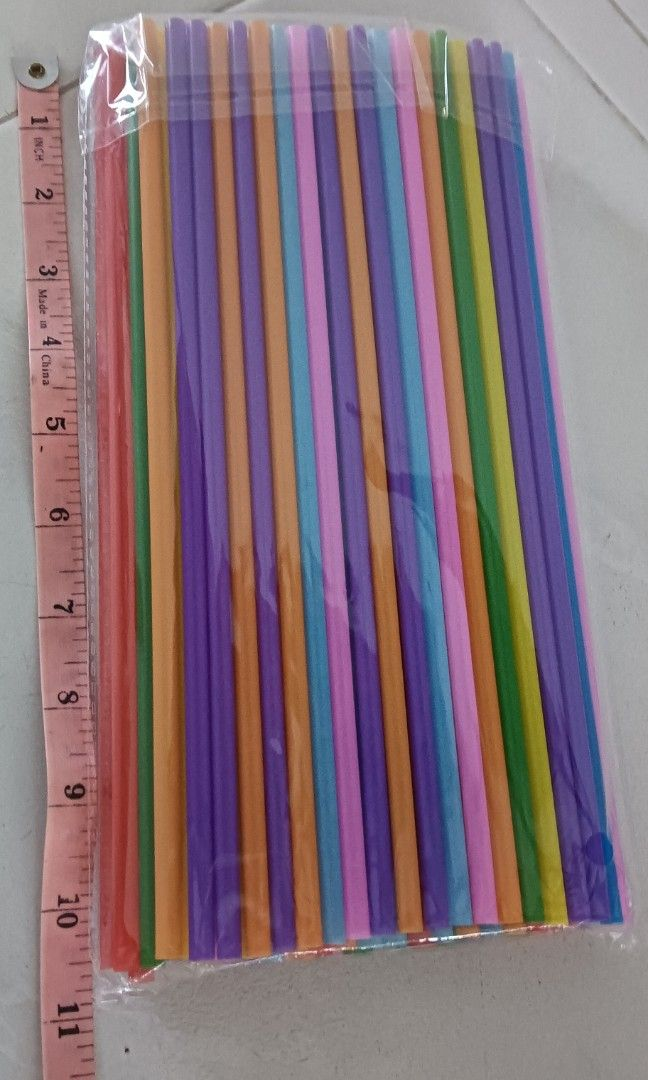

In [202]:
events[-1]

In [211]:
await checkpointer.aget(config)

{'v': 1,
 'ts': '2024-08-10T07:35:54.625722+00:00',
 'id': '1ef56eb2-d21a-6568-8020-951283dc7fb2',
 'channel_values': {'user_question': None,
  'rephrased_question': 'Is a debit card recyclable, and if so, what are the proper instructions for recycling it?',
  'items': ['debit card'],
  'retrieved_docs': [Document(metadata={'source': 'database'}, page_content='{"item": "debit card", "instructions": "Should be disposed of as general waste.", "material": "Plastic", "recyclable": false, "links": []}'),
   Document(metadata={'source': 'database'}, page_content='{"item": "bank card", "instructions": "Should be disposed of as general waste.", "material": "Plastic", "recyclable": false, "links": []}'),
   Document(metadata={'source': 'database'}, page_content='{"item": "atm card", "instructions": "Should be disposed of as general waste.", "material": "Plastic", "recyclable": false, "links": []}'),
   Document(metadata={'source': 'database'}, page_content='{"item": "expired credit cards", "ins

Checking if user text question is recycling or waste related

In [ ]:
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

IS_QUESTION_RELEVANT_PROMPT = PromptTemplate(
    template="""
    You are a grader assessing whether a question is related to recycling or waste disposal in Singapore. \n
    Return the output as a JSON according to the schema below: \n
    ```
    {{
        "is_relevant": bool,
        "item_names": List[str]
    }}
    ```
    Here is the question: ```
    {question}
    ```
    """,
    input_variables=["question"]
)

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

class IsQuestionRelevant(BaseModel):
    is_relevant: bool = Field(
        description="Boolean True or False to indicate whether the question is related to recycling or waste disposal in Singapore"
    )
    item_names: List[str] = Field(
        description="List of item names from the user's question"
    )


In [ ]:
assess_user_question_chain = IS_QUESTION_RELEVANT_PROMPT | llm.with_structured_output(schema=IsQuestionRelevant)

In [ ]:
# question = "The item is actually soft plastic. can throw in bloobin?"
question = "What's the weather like in Singapore?"
res = assess_user_question_chain.invoke({"question": question})
res

IsQuestionRelevant(is_relevant=False, item_names=['weather', 'Singapore'])

In [ ]:
items = " ".join(res.item_names)
items

'soft plastic bloobin'

In [ ]:
answer = ans_gen_chain.invoke({"questions_with_context": items})

In [ ]:
hybrid_search("how to recycle styrofoam box?", 3, 1)

[Document(metadata={'source': 'database'}, page_content='{"item": "styrofoam", "instructions": "Should be disposed of as general waste.", "material": "Plastic", "recyclable": false, "links": []}'),
 Document(metadata={'source': 'database'}, page_content='{"item": "styrofoam cup", "instructions": "Should be disposed of as general waste.", "material": "Plastic", "recyclable": false, "links": []}'),
 Document(metadata={'source': 'database'}, page_content='{"item": "cardboard box", "instructions": "Please flatten before recycling.", "material": "Paper", "recyclable": true, "links": []}')]

In [ ]:
async def is_question_relevant(state: State, config: RunnableConfig):
    question = state.question
    res = await assess_user_question_chain.ainvoke({"question": question}, config=config)
    if res.is_relevant or len(res.item_names) > 0:
        return "is_relevant"
    else:
        return "not_relevant"

### Testing

In [212]:
import operator
from typing import Annotated, List, Optional, Sequence, Dict, Any
from langchain_core.messages import BaseMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.documents import Document
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate


from langgraph.graph import StateGraph, START, END


class State(BaseModel):
    # topic: str
    joke: str = Field(default="")
    messages: Annotated[Sequence[BaseMessage], operator.add] = Field(default_factory=list)


qa_model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

prompt = PromptTemplate(
    template="""Write me a funny story about {topic}. The story should be 3 paragraphs long. Each paragraph has at least five sentences.""",
    input_variables=["topic"],
)

generate_joke_chain = prompt | qa_model


async def generate_joke(state: State, config: RunnableConfig):
    # topic = state.topic
    topic = config['configurable'].get('topic', 'monkey')
    print("-----in generate_joke node-----")
    print(f"topic: {topic}")
    res = await generate_joke_chain.ainvoke({"topic": topic}, config=config)
    return {"joke": res, "messages": [res]}

# def generate_joke(state: State, config: RunnableConfig):
#     # topic = state.topic
#     topic = config['configurable'].get('topic', 'monkey')
#     print("-----in generate_joke node-----")
#     print(f"topic: {topic}")
#     res = generate_joke_chain.invoke({"topic": topic}, config=config)
#     return {"joke": res, "messages": [res]}



In [213]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [216]:
graph_builder = StateGraph(State)
checkpointer = FirestoreDBSaver(client, "HistoryMessages")

graph_builder.add_node("generate_joke", generate_joke)
graph_builder.add_edge(START, "generate_joke")
graph_builder.add_edge("generate_joke", END)

graph = graph_builder.compile(checkpointer=checkpointer)
# graph = graph_builder.compile(checkpointer=memory)


In [217]:
from langchain_core.messages import SystemMessage, HumanMessage

state = State(messages=[])
config = {"configurable": {"topic": "giraffe", "thread_id": "137"}}
events = []
async for event in graph.astream_events(state.dict(), config=config, version="v2"):
    events.append(event)
    kind = event["event"]
    if kind == "on_chat_model_start":
        langgraph_node = event['metadata']['langgraph_node']
        if langgraph_node == "identify_image_items":
            print(f"Identifying items from image...")
    elif kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI or Anthropic usually means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="|")
    elif kind == "on_chain_end" and event["name"] == "LangGraph":
        print("END")

-----in generate_joke node-----
topic: giraffe
Once| upon| a| time|,| in| the| heart| of| the| African| sav|annah|,| there| lived| a| gir|affe| named| Gerald|.| Gerald| was| known| for| his| incredibly| long| neck|,| which| often| got| him| into| all| sorts| of| hilarious| predic|aments|.| One| day|,| while| trying| to| reach| a| particularly| juicy| leaf| at| the| top| of| a| tree|,| Gerald| accidentally| knocked| over| a| family| of| monkeys| who| were| n|apping| in| the| branches|.| The| monkeys| sc|ree|ched| and| ch|attered| angrily| at| Gerald|,| who| could| only| apologize| prof|us|ely| with| his| big|,| doe|-like| eyes|.

|Despite| his| clums|iness|,| Gerald| was| a| beloved| member| of| the| animal| community|.| His| long| neck| came| in| handy| when| it| came| to| spotting| predators| from| afar|,| and| his| gentle| nature| made| him| a| favorite| among| the| younger| animals| who| loved| to| play| games| with| him|.| One| day|,| a| mis|chie|vous| group| of| hy|enas| decided| 

In [218]:
event_names = [(i, event["name"], event["metadata"].get("langgraph_node", None), event['event']) for i, event in enumerate(events)]
event_names

[(0, 'LangGraph', None, 'on_chain_start'),
 (1, '__start__', '__start__', 'on_chain_start'),
 (2, '__start__', '__start__', 'on_chain_end'),
 (3, 'generate_joke', 'generate_joke', 'on_chain_start'),
 (4, 'RunnableSequence', 'generate_joke', 'on_chain_start'),
 (5, 'PromptTemplate', 'generate_joke', 'on_prompt_start'),
 (6, 'PromptTemplate', 'generate_joke', 'on_prompt_end'),
 (7, 'ChatOpenAI', 'generate_joke', 'on_chat_model_start'),
 (8, 'ChatOpenAI', 'generate_joke', 'on_chat_model_stream'),
 (9, 'ChatOpenAI', 'generate_joke', 'on_chat_model_stream'),
 (10, 'ChatOpenAI', 'generate_joke', 'on_chat_model_stream'),
 (11, 'ChatOpenAI', 'generate_joke', 'on_chat_model_stream'),
 (12, 'ChatOpenAI', 'generate_joke', 'on_chat_model_stream'),
 (13, 'ChatOpenAI', 'generate_joke', 'on_chat_model_stream'),
 (14, 'ChatOpenAI', 'generate_joke', 'on_chat_model_stream'),
 (15, 'ChatOpenAI', 'generate_joke', 'on_chat_model_stream'),
 (16, 'ChatOpenAI', 'generate_joke', 'on_chat_model_stream'),
 (17, 

In [219]:
events[-1]

{'event': 'on_chain_end',
 'data': {'output': {'joke': AIMessage(content='Once upon a time, in the heart of the African savannah, there lived a giraffe named Gerald. Gerald was known for his incredibly long neck, which often got him into all sorts of hilarious predicaments. One day, while trying to reach a particularly juicy leaf at the top of a tree, Gerald accidentally knocked over a family of monkeys who were napping in the branches. The monkeys screeched and chattered angrily at Gerald, who could only apologize profusely with his big, doe-like eyes.\n\nDespite his clumsiness, Gerald was a beloved member of the animal community. His long neck came in handy when it came to spotting predators from afar, and his gentle nature made him a favorite among the younger animals who loved to play games with him. One day, a mischievous group of hyenas decided to play a prank on Gerald by tying a bunch of balloons to his neck while he was sleeping. When Gerald woke up and saw himself floating in

I0000 00:00:1723275920.723476  109546 tcp_posix.cc:809] IOMGR endpoint shutdown


In [ ]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(content="hi! I'm bob")
for event in graph.stream({"messages": [input_message], "joke": "hi"}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

In [127]:
await checkpointer.aget(config)


{'v': 1,
 'ts': '2024-08-05T07:35:19.121396+00:00',
 'id': '1ef52fd4-3e75-6ca0-8007-9eafcb46c2eb',
 'channel_values': {'joke': AIMessage(content="Once upon a time, in the heart of the African savannah, there lived a giraffe named Gerald. Gerald was known for his incredibly long neck, which often got him into all sorts of hilarious predicaments. One day, while trying to reach a particularly tasty looking leaf at the top of a tree, Gerald accidentally knocked over a group of monkeys who were napping in the branches. The monkeys screeched and chattered angrily at Gerald, who could only apologize profusely with his big, doe-like eyes.\n\nDespite his clumsiness, Gerald was a beloved member of the animal community. His long neck came in handy when it came to spotting predators from afar, and his gentle nature made him a favorite among the younger animals. However, Gerald's height also made him an easy target for mischievous hyenas who loved to play pranks on him. One day, they painted spots 